In [1]:
# import libraries and modules needed
import os
import numpy
import math
from scipy import integrate
from matplotlib import pyplot

# integrate plots into the notebook
%matplotlib inline

In [2]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [3]:
def define_panels(x,y):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    N = len(x)-1
    panels = numpy.empty(N,dtype = object)
    for i in range(N):
        panels[i] = Panel(x[i],y[i],x[i+1],y[i+1])
    return panels

In [4]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [5]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [6]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [7]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [8]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty(A_source.shape[0]+1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

In [9]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [10]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[-1].beta) )
    return b

In [11]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = numpy.empty((panels.size, panels.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -numpy.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [12]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [13]:
def rotate(x,y,xc,yc,theta): 
    
    theta = theta * math.pi/180
    x, y = x - xc, y - yc                              # translating hinge point to origin
    x1 = x * math.cos(theta) + y * math.sin(theta)     # rotation 
    y1 = -x * math.sin(theta) + y * math.cos(theta)
    x, y = x1 + xc, y1 + yc                            # translating hinge point back to original position
    
    return x,y

# Airfoil Experiments

In [14]:
filepath = os.path.join('resources','naca0012.dat')
with open(filepath) as filename:
    x,y = numpy.loadtxt(filename,unpack=True)
u_inf, alpha, h = 1.0,4.0, 0.3
x,y = rotate(x,y,max(x),y[numpy.where(x==max(x))],alpha)
y = y + min(y)+ h
panels = define_panels(x, y)
panels_i = define_panels(x,-y)

freestream = Freestream(u_inf=0.5, alpha=0.0)
# freestream_i = Freestream(u_inf=0.0,alpha = 0.0)

A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

A_source_i = source_contribution_normal(panels_i)
B_vortex_i = vortex_contribution_normal(panels_i)

A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

A_i = build_singularity_matrix(A_source_i, B_vortex_i)
b_i = build_freestream_rhs(panels_i,freestream)

# solve for singularity strengths
strengths = numpy.linalg.solve(A, b)
strengths_i = numpy.linalg.solve(A_i,b_i)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
for i, panel in enumerate(panels_i):
    panel.sigma = strengths_i[i]
# store circulation density
gamma = strengths[-1]
gamma_i = strengths_i[-1]

compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)

compute_tangential_velocity(panels_i, freestream, gamma_i, A_source_i, B_vortex_i)
compute_pressure_coefficient(panels_i,freestream)

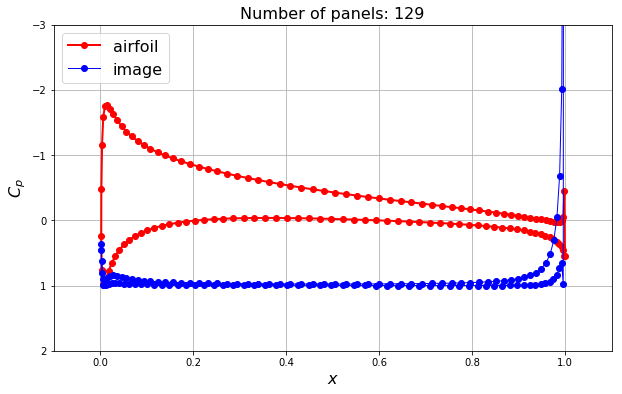

In [15]:
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels],
            [panel.cp for panel in panels],
            label='airfoil',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels_i],
            [panel.cp for panel in panels_i],
            label= 'image',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
# pyplot.axis('scaled')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(2.0, -3.0)
pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);

In [16]:
def get_velocity_field(panels, freestream, gamma, X, Y):
    """
    Computes the velocity field on a given 2D mesh.
   
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    X: 2D Numpy array of floats
        x-coordinates of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    # freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * numpy.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * numpy.ones_like(X, dtype=float)
    # add the contribution from each source
    vec_integral = numpy.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_integral(X, Y, panel, 1, 0) - gamma/(2.0*math.pi)*vec_integral(X,Y,panel,1,0)
        v += panel.sigma / (2.0 * math.pi) * vec_integral(X, Y, panel, 0, 1) - gamma/(2.0*math.pi)*vec_integral(X,Y,panel,0,1)
    
#     u -= gamma/(2.0*math.pi)*vec_integral(X,Y,panel,1,0)
#     v -= gamma/(2.0*math.pi)*vec_integral(X,Y,panel,0,1)
    return u, v

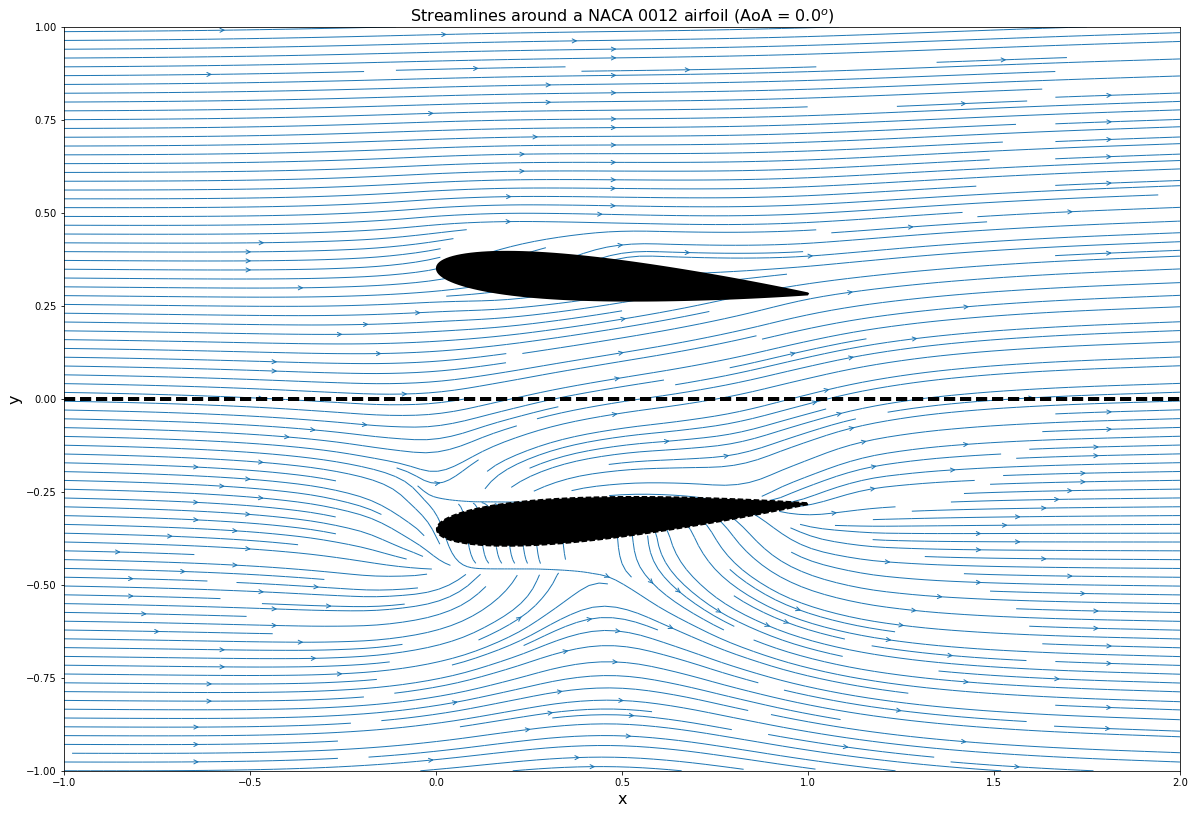

In [27]:
#defining the meshgrid
nx, ny = 20, 20  # number of points in the x and y directions
x_start, x_end = -1.0, 2.0
y_start, y_end = -1.0, 1.0
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx), numpy.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, gamma, X, Y)
u_i, v_i = get_velocity_field(panels_i, freestream, gamma, X, Y)
U = u + u_i
V = v + v_i

In [ ]:
#plotting the velocity field
width = 20
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, U, V, density=3, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],[panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.fill([panel.xc for panel in panels_i],[panel.yc for panel in panels_i],
            color='k', linestyle='--', linewidth=2, zorder=2)
pyplot.axhline(y=0, linestyle='--', linewidth=4, color='k')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(freestream.alpha), fontsize=16);

In [18]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels)
        - min(panel.xa for panel in panels))
cl = (gamma*sum(panel.length for panel in panels)
      / (0.5*freestream.u_inf*c))
print('lift coefficient: CL = {:0.3f}'.format(cl))

lift coefficient: CL = 0.604


In [19]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.001167


In [20]:
gamma

0.073826627020694285

In [29]:
import numpy

(-0.1, 0.51967665475173574)

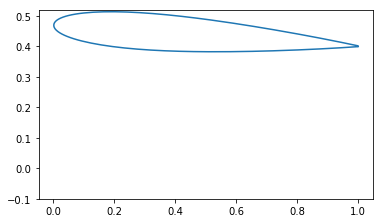

In [67]:
filepath = os.path.join('resources','naca0012.dat')
with open(filepath) as filename:
    x,y = numpy.loadtxt(filename,unpack=True)
u_inf, alpha, h = 1.0,4.0, 0.4
x,y = rotate(x,y,max(x),y[numpy.where(x==max(x))],alpha)
y = y + h
# X = numpy.concatenate((x,y))
# # Y = numpy.concatenate((y,-y))

# z = numpy.reshape(numpy.concatenate((X,Y)),(len(X),2))

# z.shape
pyplot.plot(x,y)
pyplot.axis('scaled');
pyplot.ylim(ymin = -0.1)


In [68]:
numpy.savetxt('naca.dat',[x,y])

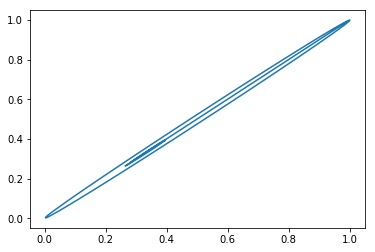

In [51]:
with open('./naca_new_0012.dat') as filename:
    x,y = numpy.loadtxt(filename, unpack=True)
    
pyplot.plot(x,y)